In [2]:
import glob
from IPython.display import display, HTML
%matplotlib inline
from image_features import *
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import RandomizedPCA, PCA
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.externals import joblib
import os
import time
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## hyper-parameters

In [3]:
# Parameters for tuning model learning. 
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 4  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

## read data

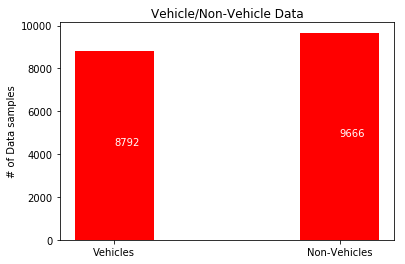

In [4]:
# import data from vehicles and not-vehicles data directories
images = glob.glob('data/*/*/*.png')

vehicles = []
nonvehicles = []
for image in images:
    if 'non-vehicles' in image:
        nonvehicles.append(image)
    else:
        vehicles.append(image)

data = (len(vehicles),len(nonvehicles))
N = 2
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(ind, data, width, color='r')
ax.set_ylabel('# of Data samples')
ax.set_title('Vehicle/Non-Vehicle Data')
ax.set_xticks(ind)
ax.set_xticklabels(('Vehicles', 'Non-Vehicles'))
for i, v in enumerate(data):
    ax.text(i, v /2, str(v), color='white')


## data visualization

In [5]:
def get_random_image(image_paths):
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def display_data(data, title):
    plt.figure(figsize=(10, 4))
    img_num = 1
    show_samples_count = 5

    for i in range(show_samples_count):
        plt.subplot(1, show_samples_count, img_num)   
        img_num += 1
        img = get_random_image(data)
        plt.imshow(img)
        plt.title("{}".format(title), fontsize=10)
        plt.axis('off')

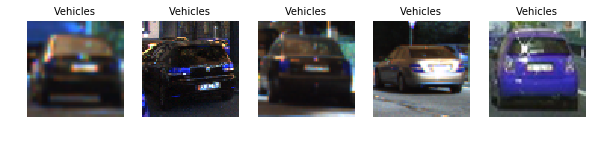

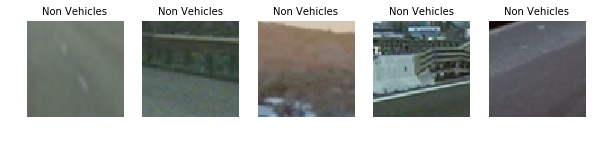

In [6]:
display_data(vehicles, "Vehicles")
display_data(nonvehicles, "Non Vehicles")

## Hog Features

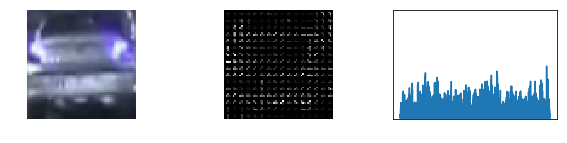

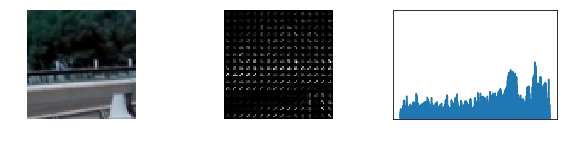

In [7]:
def plot_hog_sample(image, hog_image, hog_features):
    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot regular image
image = get_random_image(vehicles)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot hog image
image = get_random_image(nonvehicles)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                pix_per_cell=pix_per_cell, 
                cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

Above process for get_hog_features, begins with exploration of different color spaces and different skimage.hog() parameters (orientations, pixels_per_cell, and cells_per_block). I then display random images from each of the two classes and illustrate how the output of skimage.hog() output looks like.

## Color Histogram

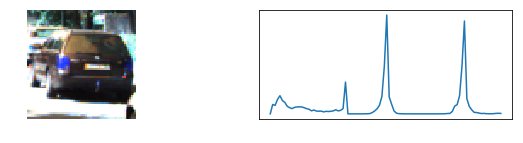

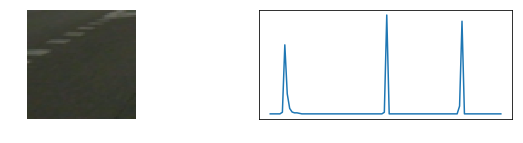

In [8]:
def plot_color_histogram_sample(image, yuv_image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(color_hist(yuv_image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive image
image = get_random_image(vehicles)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

# plot negative image
image = get_random_image(nonvehicles)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

Above is an exploration of color space, using the YUV color space and HOG parameters of orientations=8, pixels_per_cell=(4, 4) and cells_per_block=(2, 2). 


## Binned Color

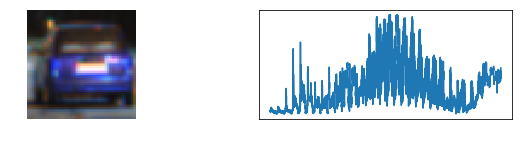

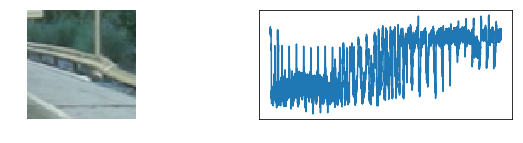

In [9]:
def plot_bin_spatial_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(vehicles)
plot_bin_spatial_sample(image)

# plot negative image
image = get_random_image(nonvehicles)
plot_bin_spatial_sample(image)

Above is an example that shows image colors binned as features. bin_spatial() function implements this.

## Extract Image features and Scaler

In [10]:
vehicle_features = extract_features_files(vehicles, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)
nonvehicle_features = extract_features_files(nonvehicles, color_space=color_space, 
                    spatial_size=spatial_size, hist_bins=hist_bins, 
                    orient=orient, pix_per_cell=pix_per_cell, 
                    cell_per_block=cell_per_block, 
                    hog_channel=hog_channel, spatial_feat=spatial_feat, 
                    hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((vehicle_features, nonvehicle_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(nonvehicle_features))))

print('Feature Scaling for Vehicles (', len(vehicle_features),') and Non-Vehicles (', len(nonvehicle_features), ') Completed')

Feature Scaling for Vehicles ( 8792 ) and Non-Vehicles ( 9666 ) Completed


## Applying PCA for dimensionality reduction

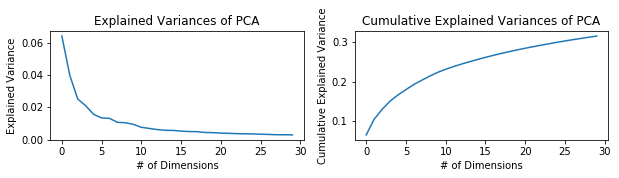

Cumulative explained variance  0.3162 by 30 number of principal components:


In [11]:
n_pca_comp = 30
pca = PCA(n_components=n_pca_comp, whiten=True)
pca = pca.fit(scaled_X)
pca_features = pca.transform(scaled_X)

# how much do we gain by PCA

explained_variance = pca.explained_variance_ratio_
components = pca.components_

# plot pca
plt.figure(figsize=(10,2))
plt.subplot(1,2,1)
plt.xlabel('# of Dimensions')
plt.ylabel('Explained Variance')
plt.title("Explained Variances of PCA")
_ = plt.plot(pca.explained_variance_ratio_)

plt.subplot(1,2,2)
plt.xlabel('# of Dimensions')
plt.ylabel('Cumulative Explained Variance')
plt.title("Cumulative Explained Variances of PCA")
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.show()


print("Cumulative explained variance  {:.4f} by {} number of principal components:".format(
    sum(explained_variance[:n_pca_comp]), n_pca_comp))


I extracted features from both the vehicles as well as non-vehicles images. The number of features become very large. Therefore I apply PCA reduction to the features, monitoring the cumulative variance that can be explained by the PCA components. This reduces the number of featres that feed into model learning

## Split data into Training and Testing

In [12]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    pca_features, y, test_size=0.2, random_state=rand_state)

print("X_train: {}, y_train: {} :: X_test: {}, y_test: {}".format(
    len(X_train), len(y_train), len(X_test), len(y_test)))

X_train: 14766, y_train: 14766 :: X_test: 3692, y_test: 3692


## Train our model using SVM - Support Vector Machine

In [13]:
# Use a linear SVC 
model = SVC(kernel='rbf', class_weight='balanced',probability=True, C = 10,gamma = 0.1)

# Check the training time for the SVC
t1=time.time()
model.fit(X_train, y_train)
t2 = time.time()
print('Time in seconds {} taken to train SVC model'.format(round(t2-t1, 2)))
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(model.score(X_test, y_test), 4))

Time in seconds 39.29 taken to train SVC model
Test Accuracy of SVC =  0.9976


99.7% accuracy is a good accuracy score, and we stop further optimization and save model to disk. 

## Save model 

In [14]:
import os

# artifacts folder
MODEL_DIR = 'model'
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
    
from sklearn.externals import joblib

## save svc
fn = MODEL_DIR + '/svc.pkl'
joblib.dump(model, fn) 

## save pca
fn = MODEL_DIR + '/pca.pkl'
joblib.dump(pca, fn) 

## save pca
fn = MODEL_DIR + '/x_scaler.pkl'
joblib.dump(X_scaler, fn) 

['model/x_scaler.pkl']

## Load model for model accuracy analysis

In [15]:
# load svm classifiers
model = joblib.load(MODEL_DIR + '/svc.pkl') 
pca = joblib.load(MODEL_DIR + '/pca.pkl') 
X_scaler = joblib.load(MODEL_DIR + '/x_scaler.pkl') 

print(model, '\n')
print(pca, '\n')
print(X_scaler, '\n')

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
  svd_solver='auto', tol=0.0, whiten=True) 

StandardScaler(copy=True, with_mean=True, with_std=True) 



In [16]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', color='red', fontsize=14)

    plt.title(title+ "\n")
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('model_confusionmatrix.png')

accuracy_score: 0.997562296858
f1_score: 0.997554156105
precision_score: 0.997634013431
recall_score: 0.997477994642


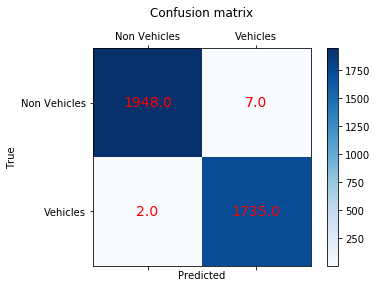

In [17]:
predictions = model.predict(X_test)
# print model metrics
print("accuracy_score:", accuracy_score(y_test, predictions))
print("f1_score:", f1_score(y_test, predictions, average="macro"))
print("precision_score:", precision_score(y_test, predictions, average="macro"))
print("recall_score:", recall_score(y_test, predictions, average="macro")) 

# sklearn confusion matrix 
cm = confusion_matrix(predictions, y_test)

# plot using matplotlib
plot_confusion_matrix(cm, labels = ['Non Vehicles', 'Vehicles'])